In [2]:
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pyfftw

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plotter
import plot_utils
import utils
import compute_statistics as cs
import data_loader
import generate_params as genp

%load_ext autoreload
%autoreload 2

2025-12-22 07:26:03.858784: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-22 07:26:03.974448: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-22 07:26:03.974487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-22 07:26:03.990360: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-22 07:26:04.025341: I tensorflow/core/platform/cpu_feature_guar

# Investigate multiplicative noise model

In [62]:
data_mode = 'muchisimocks'
statistics = ['pk', 'bispec']
#statistics = ['pk']

### train
# tag_params = '_p5_n10000'
# tag_biasparams = '_biaszen_p4_n10000'
# tag_noise = '_noise_p5_n10000'
# tag_Anoise = '_An_p1_n10000'
### test
tag_params = '_test_p5_n1000'
tag_biasparams = '_biaszen_p4_n1000'
tag_noise = '_noise_unit_test_p5_n1000'
tag_Anoise = '_Anmult_p2_n1000'
tag_datagen = ''
## cosmic variance (quijote)
# tag_params="_quijote_p0_n1000"
# tag_biasparams="_b1000_p0_n1"
# tag_noise="_noise_quijote_p0_n1000"
# tag_Anoise="_An1_p0_n1"
# tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen
k_arr, y_arr, y_err, idxs_params, params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_noise=tag_noise, tag_Anoise=tag_Anoise,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
            
print(y_arr[0].shape)
#print(y_arr[1].shape)

dir_statistics: /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p2_n1000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p2_n1000
Found 1000 diff cosmo pks in /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p2_n1000
Loaded pk data with shape (1000, 30)
fn_mask: ../data/masks/mask_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000.txt
Loading from ../data/masks/mask_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000.txt (already exists)
Masked 1 out of 30 bins
(29,) (1000, 30) (1000, 30) (30,)
dir_statistics: /scratch/kstoreyf/muchisimocks/data/bispecs_mlib/bispecs_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p2_n1000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/bispecs_mlib/bispecs_test_p5_n1000_biaszen_p4_n1000_noise_uni

In [63]:
mask = data_loader.get_Pk_mask(tag_data)

fn_mask: ../data/masks/mask_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000.txt
Loading from ../data/masks/mask_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000.txt (already exists)


In [82]:
data_mode = 'muchisimocks'
statistics = ['pk', 'bispec']
#statistics = ['pk']

### train
# tag_params = '_p5_n10000'
# tag_biasparams = '_biaszen_p4_n10000'
# tag_noise = '_noise_p5_n10000'
# tag_Anoise = '_An_p1_n10000'
### test
tag_params = '_test_p5_n1000'
tag_biasparams = '_biaszen_p4_n1000'
tag_noise = '_noise_unit_test_p5_n1000'
tag_Anoise = '_Anmult_p5_n1000'
tag_datagen = ''
## cosmic variance (quijote)
# tag_params="_quijote_p0_n1000"
# tag_biasparams="_b1000_p0_n1"
# tag_noise="_noise_quijote_p0_n1000"
# tag_Anoise="_An1_p0_n1"
# tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen
k_arr_np5, y_arr_np5, y_err_np5, idxs_params_np5, params_df_np5, param_dict_fixed_np5, biasparams_df_np5, biasparams_dict_fixed_np5, Anoise_df_np5, Anoise_dict_fixed_np5, random_ints_np5, random_ints_bias_np5 = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_noise=tag_noise, tag_Anoise=tag_Anoise,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
            
print(y_arr_np5[0].shape)
#print(y_arr[1].shape)

dir_statistics: /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000
Found 1000 diff cosmo pks in /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000
Loaded pk data with shape (1000, 30)
fn_mask: ../data/masks/mask_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000.txt
Loading from ../data/masks/mask_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000.txt (already exists)
Masked 1 out of 30 bins
(29,) (1000, 30) (1000, 30) (30,)
dir_statistics: /scratch/kstoreyf/muchisimocks/data/bispecs_mlib/bispecs_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/bispecs_mlib/bispecs_test_p5_n1000_biaszen_p4_n1000_noise_uni

In [83]:
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
tag_data_train = None # this is used for mask; we get it below 
statistics = ['pk', 'bispec']
k_mock, y_mock, y_err_mock = data_loader.load_data_ood(data_mode_test, statistics, tag_mock, tag_data=tag_data_train)

Loaded pk with shape (30,)
Loaded pk data with shape (30,)
No tag_data provided, so not masking data
Loaded bispec with shape (50,)
Loaded bispec data with shape (50,)
No tag_data provided, so not masking data


In [84]:
# unpack the stats
k_pk = k_arr[statistics.index('pk')]
y_pk = y_arr[statistics.index('pk')]

k_bispec = k_arr[statistics.index('bispec')]
y_bispec = y_arr[statistics.index('bispec')]

pk_shame = y_mock[0][mask]
bispec_shame = y_mock[1]

In [103]:
# Compute chi2 between shame mock and all test power spectra
chi2_values_pk = np.zeros(y_pk.shape[0])

for i in range(y_pk.shape[0]):
    pk_test = y_pk[i]
    chi2_values_pk[i] = np.sum((pk_test - pk_shame)**2/pk_shame)  # avoid division by zero

# Find minimum chi2
idx_min_pk = np.argmin(chi2_values_pk)
min_chi2_pk = chi2_values_pk[idx_min_pk]
print(idx_min_pk, min_chi2_pk)

537 18085.1772486139


In [105]:
# Compute chi2 between shame mock and all test power spectra
chi2_values_bispec = np.zeros(y_bispec.shape[0])

for i in range(y_bispec.shape[0]):
    bispec_test = y_bispec[i]
    chi2_values_bispec[i] = np.sum((bispec_test - bispec_shame)**2/bispec_shame)  # avoid division by zero
# Find minimum chi2
idx_min_bispec = np.argmin(chi2_values_bispec)
min_chi2_bispec = chi2_values_bispec[idx_min_bispec]
print(idx_min_bispec, min_chi2_bispec)

307 268430.0024369728


In [107]:
# Compute chi2 between shame mock and all test power spectra
chi2_values_pk_bispec = np.zeros(y_bispec.shape[0])
pk_bispec_shame = np.concatenate([pk_shame, bispec_shame])

for i in range(y_bispec.shape[0]):
    pk_bispec_test = np.concatenate([y_pk[i], y_bispec[i]])
    chi2_values_pk_bispec[i] = np.sum((pk_bispec_test - pk_bispec_shame)**2/pk_bispec_shame)  # avoid division by zero
# Find minimum chi2
idx_min_pk_bispec = np.argmin(chi2_values_pk_bispec)
min_chi2_pk_bispec = chi2_values_pk_bispec[idx_min_pk_bispec]
print(idx_min_pk_bispec, min_chi2_pk_bispec)

307 352865.0563984815


In [108]:
# unpack the stats
k_pk_np5 = k_arr_np5[statistics.index('pk')]
y_pk_np5 = y_arr_np5[statistics.index('pk')]

k_bispec_np5 = k_arr_np5[statistics.index('bispec')]
y_bispec_np5 = y_arr_np5[statistics.index('bispec')]

In [109]:
# Compute chi2 between shame mock and all test power spectra
chi2_values_pk_np5 = np.zeros(y_pk_np5.shape[0])

for i in range(y_pk_np5.shape[0]):
    pk_test = y_pk_np5[i]
    chi2_values_pk_np5[i] = np.sum((pk_test - pk_shame)**2/pk_shame)  # avoid division by zero
# Find minimum chi2
idx_min_pk_np5 = np.argmin(chi2_values_pk_np5)
min_chi2_pk_np5 = chi2_values_pk_np5[idx_min_pk_np5]
print(idx_min_pk_np5, min_chi2_pk_np5)

791 18470.028197900454


In [110]:
# Compute chi2 between shame mock and all test power spectra
chi2_values_bispec_np5 = np.zeros(y_bispec_np5.shape[0])

for i in range(y_bispec_np5.shape[0]):
    bispec_test = y_bispec_np5[i]
    chi2_values_bispec_np5[i] = np.sum((bispec_test - bispec_shame)**2/bispec_shame)  # avoid division by zero
# Find minimum chi2
idx_min_bispec_np5 = np.argmin(chi2_values_bispec_np5)
min_chi2_bispec_np5 = chi2_values_bispec_np5[idx_min_bispec_np5]
#print((y_pk[min_idx] - pk_shame)/(pk_shame))
print(idx_min_bispec_np5, min_chi2_bispec_np5)

483 1393748.8335242711


In [111]:
# Compute chi2 between shame mock and all test power spectra
chi2_values_pk_bispec_np5 = np.zeros(y_bispec_np5.shape[0])

for i in range(y_bispec_np5.shape[0]):
    pk_bispec_test = np.concatenate([y_pk_np5[i], y_bispec_np5[i]])
    pk_bispec_shame = np.concatenate([pk_shame, bispec_shame])
    chi2_values_pk_bispec_np5[i] = np.sum((pk_bispec_test - pk_bispec_shame)**2/pk_bispec_shame)  # avoid division by zero
# Find minimum chi2
idx_min_pk_bispec_np5 = np.argmin(chi2_values_pk_bispec_np5)
min_chi2_pk_bispec_np5 = chi2_values_pk_bispec_np5[idx_min_pk_bispec_np5]
print(idx_min_pk_bispec_np5, min_chi2_pk_bispec_np5)

483 1449237.3118135384


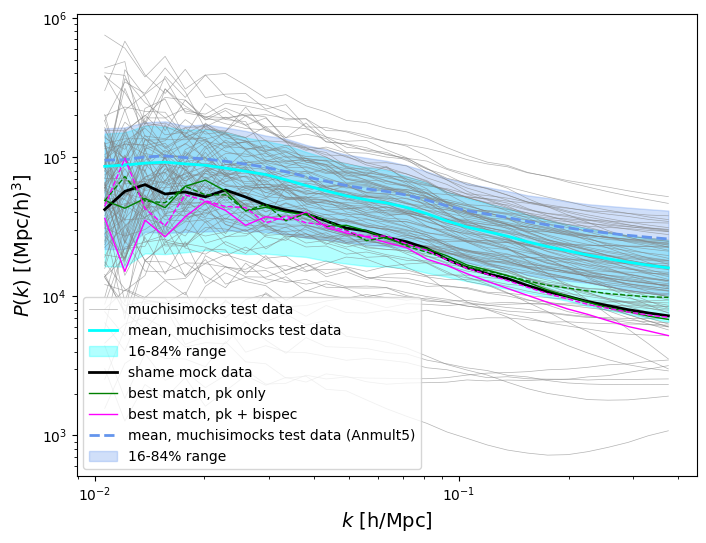

In [112]:

plt.figure(figsize=(8,6))

n_plot = np.min([100, y_pk.shape[0]])
first = True
for i in range(n_plot):
    if first:
        label = 'muchisimocks test data'
        first = False
    else:
        label = None
    plt.plot(k_pk, y_pk[i], color='grey', alpha=0.6, lw=0.5, label=label)

mean = np.mean(y_pk, axis=0)
p16 = np.percentile(y_pk, 16, axis=0)
p84 = np.percentile(y_pk, 84, axis=0)

plt.plot(k_pk, mean, color='cyan', lw=2, label='mean, muchisimocks test data')
plt.fill_between(k_pk, p16, p84, color='cyan', alpha=0.3, label=r'16-84% range')

plt.plot(k_mock[0][mask], y_mock[0][mask], color='black', lw=2, label='shame mock data')
plt.plot(k_pk, y_pk[idx_min_pk], color='green', lw=1, label='best match, pk only')
plt.plot(k_pk, y_pk[idx_min_pk_bispec], color='magenta', lw=1, label='best match, pk + bispec')

## Anmult p5

mean = np.mean(y_pk_np5, axis=0)
p16 = np.percentile(y_pk_np5, 16, axis=0)
p84 = np.percentile(y_pk_np5, 84, axis=0)
plt.plot(k_pk_np5, mean, color='cornflowerblue', lw=2, ls='--', label='mean, muchisimocks test data (Anmult5)')
plt.fill_between(k_pk_np5, p16, p84, color='cornflowerblue', alpha=0.3, label=r'16-84% range')
plt.plot(k_pk_np5, y_pk_np5[idx_min_pk_np5], color='green', lw=1, ls='--')
plt.plot(k_pk_np5, y_pk_np5[idx_min_pk_bispec_np5], color='magenta', lw=1, ls='--')


plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)
plt.legend(fontsize=10)

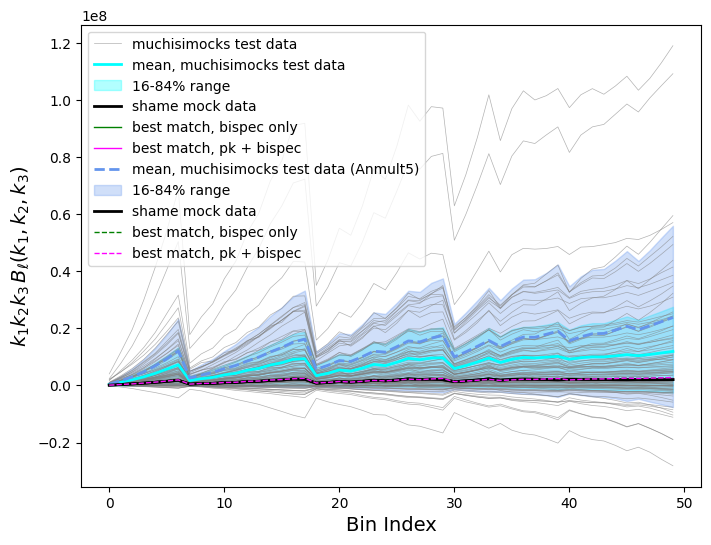

In [113]:
plt.figure(figsize=(8,6))

n_plot = 100
first = True
for i in range(n_plot):
    if first:
        label = 'muchisimocks test data'
        first = False
    else:
        label = None
    plt.plot(range(len(y_bispec[i])), y_bispec[i], color='grey', alpha=0.6, lw=0.5, label=label)

mean = np.mean(y_bispec, axis=0)
p16 = np.percentile(y_bispec, 16, axis=0)
p84 = np.percentile(y_bispec, 84, axis=0)
plt.plot(range(len(mean)), mean, color='cyan', lw=2, label='mean, muchisimocks test data')
plt.fill_between(range(len(mean)), p16, p84, color='cyan', alpha=0.3, label=r'16-84% range')
plt.plot(range(len(bispec_shame)), bispec_shame, color='black', lw=2, label='shame mock data')
plt.plot(range(len(y_bispec[idx_min_bispec])), y_bispec[idx_min_bispec], color='green', lw=1, label='best match, bispec only')
plt.plot(range(len(y_bispec[idx_min_pk_bispec])), y_bispec[idx_min_pk_bispec], color='magenta', lw=1, label='best match, pk + bispec')
plt.plot()

## Anmult p5
mean = np.mean(y_bispec_np5, axis=0)
p16 = np.percentile(y_bispec_np5, 16, axis=0)
p84 = np.percentile(y_bispec_np5, 84, axis=0)
plt.plot(range(len(mean)), mean, color='cornflowerblue', ls='--', lw=2, label='mean, muchisimocks test data (Anmult5)')
plt.fill_between(range(len(mean)), p16, p84, color='cornflowerblue', alpha=0.3, label=r'16-84% range')
plt.plot(range(len(bispec_shame)), bispec_shame, color='black', lw=2, label='shame mock data')
plt.plot(range(len(y_bispec_np5[idx_min_bispec_np5])), y_bispec_np5[idx_min_bispec_np5], color='green', ls='--', lw=1, label='best match, bispec only')
plt.plot(range(len(y_bispec_np5[idx_min_pk_bispec_np5])), y_bispec_np5[idx_min_pk_bispec_np5], color='magenta', ls='--', lw=1, label='best match, pk + bispec')
plt.plot()


plt.xlabel(r'Bin Index', fontsize=14)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$', fontsize=14)
plt.legend(fontsize=10)
#plt.ylim(p16.min()*2, p84.max()*0.8)

(59711.70889793794, 4595707.170184825)

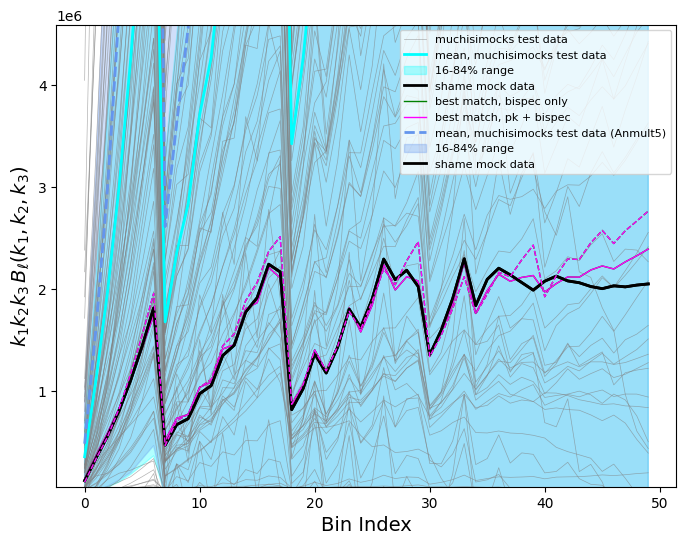

In [115]:
plt.figure(figsize=(8,6))

n_plot = 100
first = True
for i in range(n_plot):
    if first:
        label = 'muchisimocks test data'
        first = False
    else:
        label = None
    plt.plot(range(len(y_bispec[i])), y_bispec[i], color='grey', alpha=0.6, lw=0.5, label=label)

mean = np.mean(y_bispec, axis=0)
p16 = np.percentile(y_bispec, 16, axis=0)
p84 = np.percentile(y_bispec, 84, axis=0)
plt.plot(range(len(mean)), mean, color='cyan', lw=2, label='mean, muchisimocks test data')
plt.fill_between(range(len(mean)), p16, p84, color='cyan', alpha=0.3, label=r'16-84% range')
plt.plot(range(len(bispec_shame)), bispec_shame, color='black', lw=2, label='shame mock data')
plt.plot(range(len(y_bispec[idx_min_bispec])), y_bispec[idx_min_bispec], color='green', lw=1, label='best match, bispec only')
plt.plot(range(len(y_bispec[idx_min_pk_bispec])), y_bispec[idx_min_pk_bispec], color='magenta', lw=1, label='best match, pk + bispec')
plt.plot()

## Anmult p5
mean = np.mean(y_bispec_np5, axis=0)
p16 = np.percentile(y_bispec_np5, 16, axis=0)
p84 = np.percentile(y_bispec_np5, 84, axis=0)
plt.plot(range(len(mean)), mean, color='cornflowerblue', ls='--', lw=2, label='mean, muchisimocks test data (Anmult5)')
plt.fill_between(range(len(mean)), p16, p84, color='cornflowerblue', alpha=0.3, label=r'16-84% range')
plt.plot(range(len(bispec_shame)), bispec_shame, color='black', lw=2, label='shame mock data')
plt.plot(range(len(y_bispec_np5[idx_min_bispec_np5])), y_bispec_np5[idx_min_bispec_np5], color='green', ls='--', lw=1)
plt.plot(range(len(y_bispec_np5[idx_min_pk_bispec_np5])), y_bispec_np5[idx_min_pk_bispec_np5], color='magenta', ls='--', lw=1)
plt.plot()


plt.xlabel(r'Bin Index', fontsize=14)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$', fontsize=14)
plt.legend(fontsize=8)
plt.ylim(bispec_shame.min()*0.5, bispec_shame.max()*2)

# inference

## load training: Anmult p2

In [3]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n10000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p2_n10000'

n_train = 10000
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
tags_inf = [
             f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}_ntrain{n_train}' for tag_stats in tag_stats_arr
            ]
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [9]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1']


### Inference results: cosmic variance / fixed cosmo (quijote)

In [20]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_noise_fixed = '_noise_unit_quijote_p0_n1000'
tag_Anoise_fixed = '_Anmult_p0_n1'
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                               tag_Anoise_test=tag_Anoise_fixed,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary,
                                noise_param_names_vary=noise_param_names_vary)
print(theta_test_fixed)
print(len(theta_test_fixed))

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params_test_fixed)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams_test_fixed)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise_fixed)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

tag_Anoise_test _Anmult_p0_n1
['An_homog', 'An_b1']
{'An_homog': 1.0, 'An_b1': 0.0, 'An_b2': 0.0, 'An_bs2': 0.0, 'An_bl': 0.0}
here
11
[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.     1.
 0.    ]
11


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p2_n10000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p2_n10000_ntrain10000/samples_test_muchisimocks_bispec_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p2_n10000_ntrain10000/samples_test_muchisimocks_pk_bispec_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy


Parameter b2 in chain $P(k)$ is not constrained


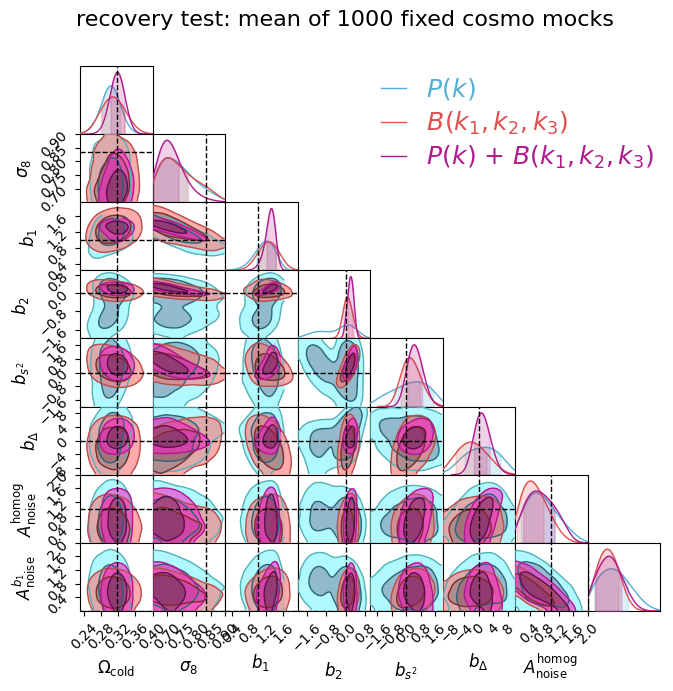

In [21]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tags_test = ['_'+data_mode + tag_stats + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for tag_stats in tag_stats_arr]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

### Inference results: shame

In [24]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock, 
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary, noise_param_names_vary=noise_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47410742
  0.03175373 -0.16940883 -0.82443643         nan         nan]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p2_n10000_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p2_n10000_ntrain10000/samples_test_shame_bispec_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p2_n10000_ntrain10000/samples_test_shame_pk_bispec_nbar0.00022_pred.npy


Parameter bl in chain $P(k)$ is not constrained


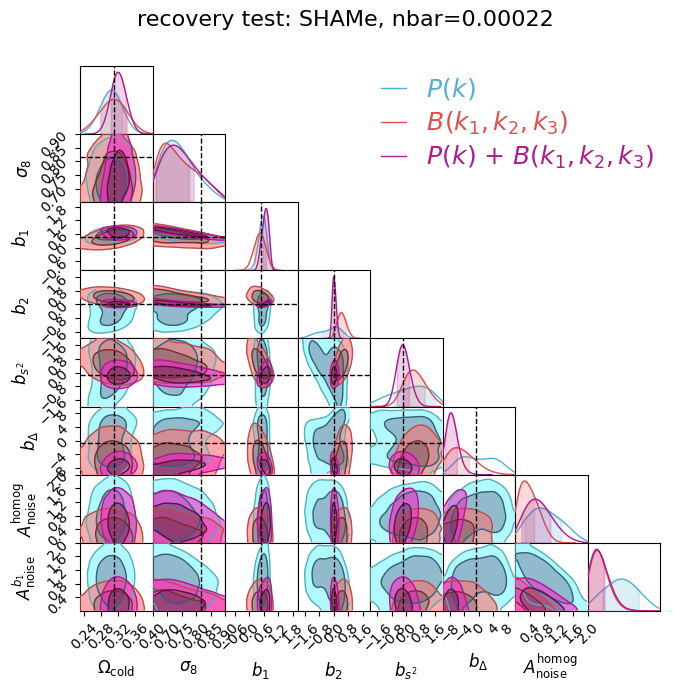

In [26]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats + tag_mock for tag_stats in tag_stats_arr]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

## load training: Anmult p5

In [27]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n10000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p5_n10000'

n_train = 10000
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
tags_inf = [
             f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}_ntrain{n_train}' for tag_stats in tag_stats_arr
            ]
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [28]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']


### Inference results: cosmic variance / fixed cosmo (quijote)

In [29]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_noise_fixed = '_noise_unit_quijote_p0_n1000'
tag_Anoise_fixed = '_Anmult_p0_n1'
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                               tag_Anoise_test=tag_Anoise_fixed,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary,
                                noise_param_names_vary=noise_param_names_vary)
print(theta_test_fixed)
print(len(theta_test_fixed))

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params_test_fixed)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams_test_fixed)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise_fixed)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

tag_Anoise_test _Anmult_p0_n1
['An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
{'An_homog': 1.0, 'An_b1': 0.0, 'An_b2': 0.0, 'An_bs2': 0.0, 'An_bl': 0.0}
here
14
[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.     1.
 0.     0.     0.     0.    ]
14


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000_ntrain10000/samples_test_muchisimocks_bispec_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000_ntrain10000/samples_test_muchisimocks_pk_bispec_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy


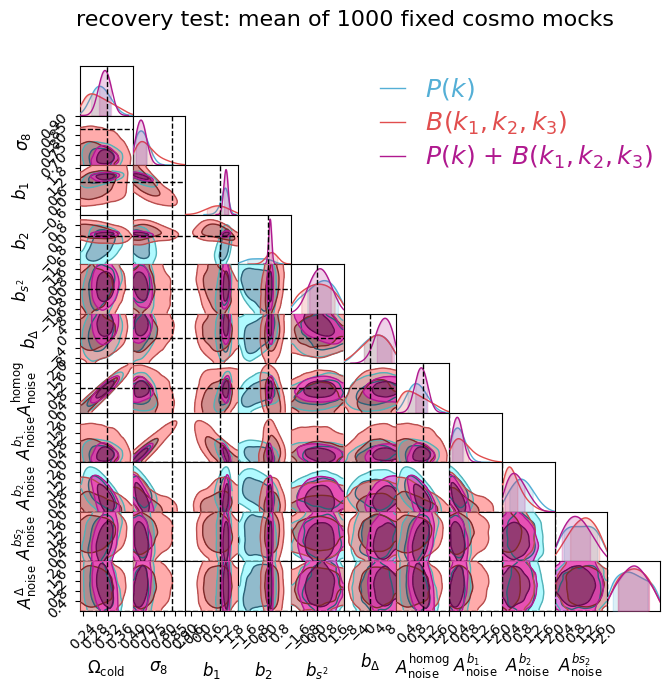

In [30]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tags_test = ['_'+data_mode + tag_stats + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for tag_stats in tag_stats_arr]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

### Inference results: shame

In [31]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock, 
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary, noise_param_names_vary=noise_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47410742
  0.03175373 -0.16940883 -0.82443643         nan         nan         nan
         nan         nan]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000_ntrain10000/samples_test_shame_bispec_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000_ntrain10000/samples_test_shame_pk_bispec_nbar0.00022_pred.npy


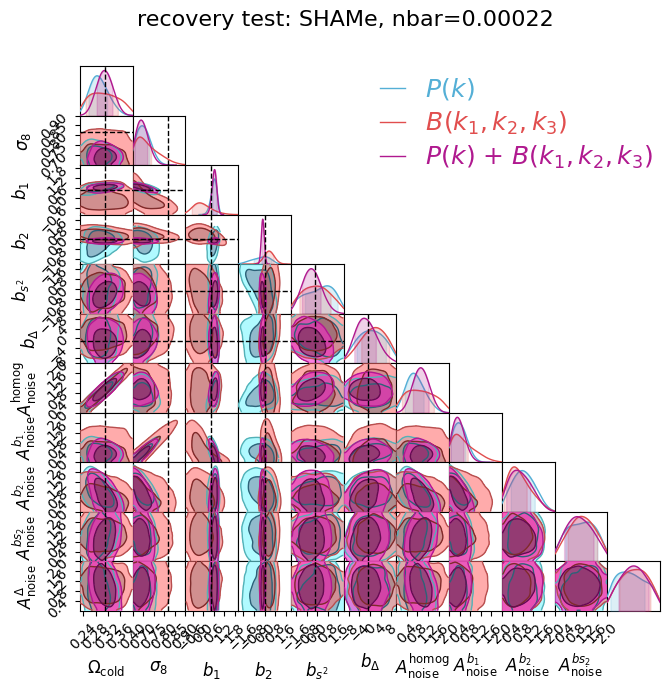

In [32]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats + tag_mock for tag_stats in tag_stats_arr]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)